In [1]:
!pip install tensorflow opencv-contrib-python youtube-dl moviepy pydot --user --no-warn-script-location
!pip install git+https://github.com/TahaAnwar/pafy.git#egg=pafy

  Cloning https://github.com/TahaAnwar/pafy.git to c:\users\fracc\appdata\local\temp\pip-install-ahsb2zmu\pafy_88531992b0d84c5d80144b079390c102
  Resolved https://github.com/TahaAnwar/pafy.git to commit 2f3c473b3df7961721d07e1504675313afd1d2cb


  Running command git clone -q https://github.com/TahaAnwar/pafy.git 'C:\Users\fracc\AppData\Local\Temp\pip-install-ahsb2zmu\pafy_88531992b0d84c5d80144b079390c102'


In [2]:
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [3]:
#Numpy, Python, and Tensorflow seed to get consistent resusts on every execution
# Allow us to restrict the randomsness

seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [4]:
# Create a Matplotlib figure and specify the size of the figure.
plt.figure(figsize = (20, 20))

# Get the names of all classes/categories in UCF50.
all_classes_names = os.listdir('dataset/UCF50')



<Figure size 1440x1440 with 0 Axes>

In [5]:
# Generate a list of 20 random values. The values will be between 0-50, 
# where 50 is the total number of class in the dataset. 
random_range = random.sample(range(len(all_classes_names)), 20)


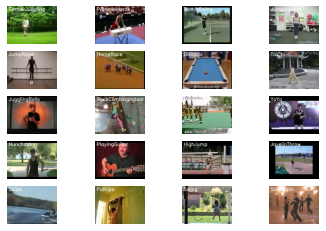

In [6]:
# Iterating through all the generated random values.
for counter, random_index in enumerate(random_range, 1):

    # Retrieve a Class Name using the Random Index.
    selected_class_Name = all_classes_names[random_index]

    # Retrieve the list of all the video files present in the randomly selected Class Directory.
    video_files_names_list = os.listdir(f'dataset/UCF50/{selected_class_Name}')

    # Randomly select a video file from the list retrieved from the randomly selected Class Directory.
    selected_video_file_name = random.choice(video_files_names_list)

    # Initialize a VideoCapture object to read from the video File.
    video_reader = cv2.VideoCapture(f'dataset/UCF50/{selected_class_Name}/{selected_video_file_name}')
    
    # Read the first frame of the video file.
    _, bgr_frame = video_reader.read()

    # Release the VideoCapture object. 
    video_reader.release()

    # Convert the frame from BGR into RGB format. 
    rgb_frame = cv2.cvtColor(bgr_frame, cv2.COLOR_BGR2RGB)

    # Write the class name on the video frame.
    cv2.putText(rgb_frame, selected_class_Name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    
    # Display the frame.
    plt.subplot(5, 4, counter);plt.imshow(rgb_frame);plt.axis('off')

In [7]:
# Processing the Dataset

image_height, image_width = 64, 64

sequence_length = 20

dataset_dir = "dataset/UCF50"

classes_list = ["WalkingWithDog", "TaiChi", "Swing", "HorseRace"]

In [8]:
def frames_extraction(video_path):
    
    frames_list = []
    
    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/sequence_length), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(sequence_length):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video. 
        success, frame = video_reader.read() 

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (image_height, image_width))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255
        
        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)
    
    # Release the VideoCapture object. 
    video_reader.release()

    # Return the frames list.
    return frames_list

In [9]:
def create_dataset():
    features = []
    labels = []
    video_files_paths = []
    
    # Iterating through all the classes mentioned in the classes list
    for class_index, class_name in enumerate(classes_list):
        
        # Display the name of the class whose data is being extracted.
        print(f'Extracting Data of Class: {class_name}')
        
        # Get the list of video files present in the specific class name directory.
        files_list = os.listdir(os.path.join(dataset_dir, class_name))
        
        # Iterate through all the files present in the files list.
        for file_name in files_list:
            
            # Get the complete video path.
            video_file_path = os.path.join(dataset_dir, class_name, file_name)

            # Extract the frames of the video file.
            frames = frames_extraction(video_file_path)

            # Check if the extracted frames are equal to the SEQUENCE_LENGTH specified above.
            # So ignore the vides having frames less than the SEQUENCE_LENGTH.
            if len(frames) == sequence_length:

                # Append the data to their repective lists.
                features.append(frames)
                labels.append(class_index)
                video_files_paths.append(video_file_path)

    # Converting the list to numpy arrays
    features = np.asarray(features)
    labels = np.array(labels)  
    
    # Return the frames, class index, and video file path.
    return features, labels, video_files_paths

In [10]:
features, labels, video_files_paths = create_dataset()

Extracting Data of Class: WalkingWithDog
Extracting Data of Class: TaiChi
Extracting Data of Class: Swing
Extracting Data of Class: HorseRace


In [11]:
one_hot_encoded_labels = to_categorical(labels)

In [12]:
features_train, features_test, labels_train, labels_test = train_test_split(features, one_hot_encoded_labels
                                                                            , test_size = 0.25, shuffle = True,
                                                                            random_state = seed_constant)

In [13]:
# Paper for this Model here URL=https://arxiv.org/pdf/1411.4389.pdf

def create_LRCN_model():
    
    model = Sequential()
    
    model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu'),
                              input_shape=(sequence_length, image_height, image_width, 3)))
    
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((4, 4))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    model.add(TimeDistributed(Dropout(0.25)))
    
    model.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
    model.add(TimeDistributed(MaxPooling2D((2, 2))))
    
    model.add(TimeDistributed(Flatten()))
    
    model.add(LSTM(32))
    
    model.add(Dense(len(classes_list), activation='softmax'))
    
    model.summary()
    
    return model
    

In [14]:
LRCN_model = create_LRCN_model()

print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 64, 64, 16)   448       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 20, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 20, 16, 16, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 20, 16, 16, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 20, 4, 4, 32)     0

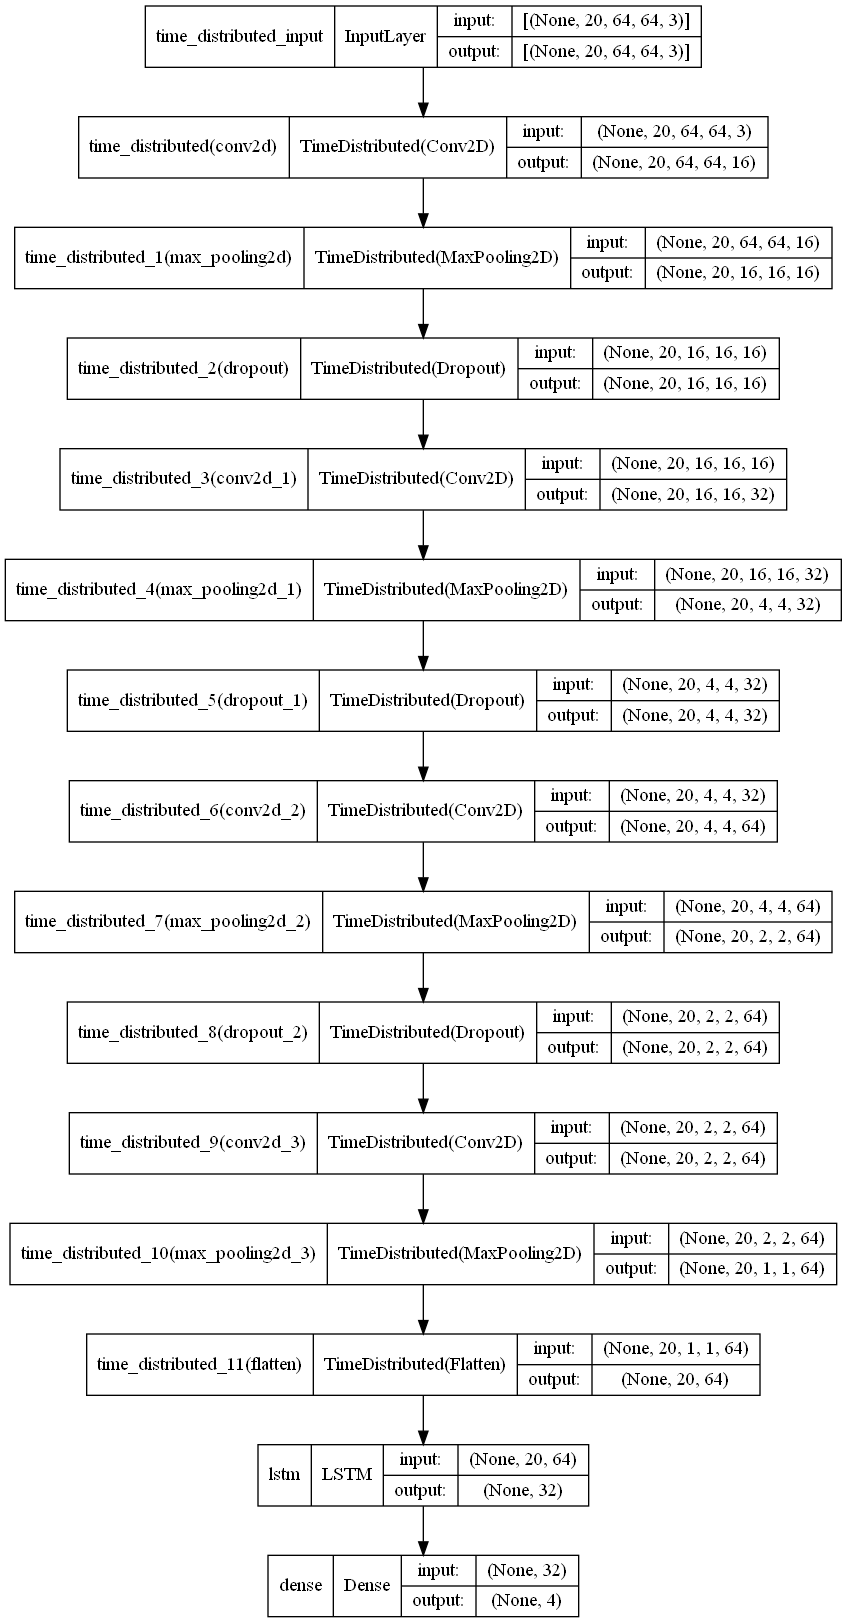

In [15]:
# In order to vizualize the model it is need pydot and graphviz
# pip install pydot, and install graphviz and add graphviz to path

plot_model(LRCN_model, to_file = 'LRCN_model_strucure_plot.png', show_shapes = True, show_layer_names = True)

In [16]:
early_stopping_callback = EarlyStopping(monitor = 'val_loss', patience = 15, mode = 'min', restore_best_weights = True)

LRCN_model.compile(loss = 'categorical_crossentropy', optimizer = 'Adam', metrics = ['accuracy'])

LRCN_model_training_history = LRCN_model.fit(x = features_train, y = labels_train, epochs = 70, batch_size = 4,
                                                    shuffle = True, validation_split = 0.2,
                                                    callbacks = [early_stopping_callback])

Epoch 1/70
73/73 [==============================] - 6s 25ms/step - loss: 1.3927 - accuracy: 0.2466 - val_loss: 1.3622 - val_accuracy: 0.3562
Epoch 2/70
73/73 [==============================] - 1s 16ms/step - loss: 1.3640 - accuracy: 0.2911 - val_loss: 1.3704 - val_accuracy: 0.3288
Epoch 3/70
73/73 [==============================] - 1s 15ms/step - loss: 1.3017 - accuracy: 0.4589 - val_loss: 1.3594 - val_accuracy: 0.3014
Epoch 4/70
73/73 [==============================] - 1s 16ms/step - loss: 1.2143 - accuracy: 0.4384 - val_loss: 1.4530 - val_accuracy: 0.2055
Epoch 5/70
73/73 [==============================] - 1s 16ms/step - loss: 1.0485 - accuracy: 0.5719 - val_loss: 0.9535 - val_accuracy: 0.5753
Epoch 6/70
73/73 [==============================] - 1s 17ms/step - loss: 0.8930 - accuracy: 0.6541 - val_loss: 1.1183 - val_accuracy: 0.5753
Epoch 7/70
73/73 [==============================] - 1s 15ms/step - loss: 0.8324 - accuracy: 0.6438 - val_loss: 0.8515 - val_accuracy: 0.6849
Epoch 8/70
73

In [17]:
model_evaluation_history = LRCN_model.evaluate(features_test, labels_test)

4/4 [==============================] - 1s 81ms/step - loss: 0.3354 - accuracy: 0.9098


In [18]:
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)

model_file_name = f'LRCN_model__Date_Time_{current_date_time_string}__Loss_{model_evaluation_loss}__Accuraccy_{model_evaluation_accuracy}.h5'

LRCN_model.save(model_file_name)

In [19]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]
    
    epochs = range(len(metric_value_1))
    
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)
    
    plt.title(str(plot_name))
    
    plt.legend()

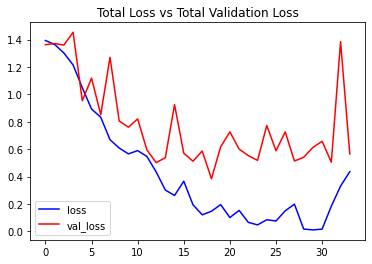

In [20]:
plot_metric(LRCN_model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

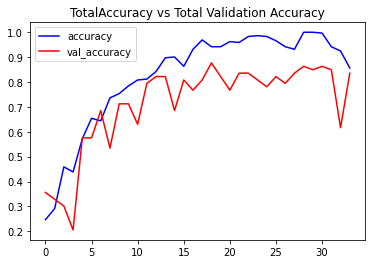

In [21]:
plot_metric(LRCN_model_training_history, 'accuracy', 'val_accuracy', 'TotalAccuracy vs Total Validation Accuracy')